Shape of the data: (96, 9)


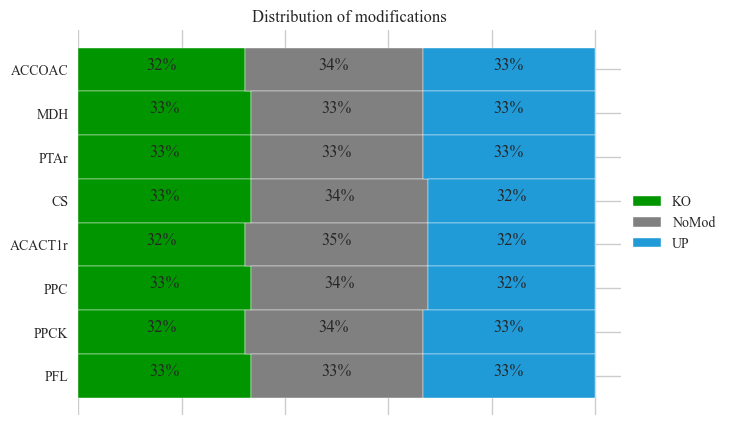

In [1]:
import sys
sys.path.append("../")

import warnings
import pickle
import numpy as np
import pandas as pd
from IPython.display import display
from pycaret.regression import *
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from src import plot_multiomics

warnings.simplefilter(action="ignore", category=FutureWarning)

file_path = "../data/EDD_isoprenol_production.csv"

INPUT_VARS = ["ACCOAC", "MDH", "PTAr", "CS", "ACACT1r", "PPC", "PPCK", "PFL"]
RESPONSE_VARS = ["Value"]

df = pd.read_csv(file_path, index_col=0)
df = df[INPUT_VARS + RESPONSE_VARS]
df[INPUT_VARS] = df[INPUT_VARS].astype(int)
print(f"Shape of the data: {df.shape}")
plot_multiomics.plot_distribution_of_designs(df[INPUT_VARS])

In [2]:
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Linear Regression
linear_param_grid = {
    'fit_intercept': [True, False],
}

# Ridge Regression
ridge_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100],
    'fit_intercept': [True, False],
}

# Lasso Regression
lasso_param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100],
    'fit_intercept': [True, False],
}

# K-Nearest Neighbors Regression
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 10, 15, 20],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Random Forest Regression
rf_param_grid = {
    'n_estimators': [5, 10, 20, 25, 50],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Support Vector Regression
svr_param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.01, 0.001],
    'gamma': [1, 0.1, 0.01, 0.001]
}

# CatBoost Regression
catboost_param_grid = {
    'iterations': [10, 30, 50],
    'learning_rate': [0.01, 0.05, 0.1, 1.0],
    'depth': [4, 6, 8, 10, 12]
}

# LightGBM Regression
lgbm_param_grid = {
    'boosting_type': ['gbdt', 'dart', 'goss'],
    'num_leaves': [3, 5, 12, 20],
    'learning_rate': [0.01, 0.1, 1.0, 10.0],
    'n_estimators': [5, 10, 20, 50]
}

# XGBoost Regression
xgb_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.1, 1.0],
    'n_estimators': [10, 25, 30, 50, 100],
    'min_child_weight': [1, 3, 5],
    'gamma': [0.0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5],
    'reg_lambda': [0.0, 0.1, 0.5]
}

def nestedCV(model, p_grid, X, y):
    print(model.__class__.__name__)
    nested_scores = []
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)
    outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = RandomizedSearchCV(estimator=model, scoring='neg_mean_absolute_error', param_distributions=p_grid, cv=inner_cv, n_iter=100)
    nested_score = cross_val_score(grid, X=X, y=y, scoring='neg_mean_absolute_error', cv=outer_cv)
    nested_scores.append(list(nested_score))
    return model, nested_scores

In [4]:
import warnings
warnings.filterwarnings("ignore")

X_train = df[INPUT_VARS]
y_train = df[RESPONSE_VARS].values.ravel()

nested_catboost, nested_catboost_scores = nestedCV(CatBoostRegressor(verbose=False), catboost_param_grid, X_train, y_train)
nested_lgbm, nested_lgbm_scores = nestedCV(LGBMRegressor(), lgbm_param_grid, X_train, y_train)
nested_xgb, nested_xgb_scores = nestedCV(XGBRegressor(n_jobs=-1), xgb_param_grid, X_train, y_train)
nested_LR, nested_LR_scores = nestedCV(LinearRegression(), linear_param_grid, X_train, y_train)
nested_ridge, nested_ridge_scores = nestedCV(Ridge(), ridge_param_grid, X_train, y_train)
nested_lasso, nested_lasso_scores = nestedCV(Lasso(), lasso_param_grid, X_train, y_train)
nested_knn, nested_knn_scores = nestedCV(KNeighborsRegressor(), knn_param_grid, X_train, y_train)
nested_rf, nested_rf_scores = nestedCV(RandomForestRegressor(), rf_param_grid, X_train, y_train)
nested_svr, nested_svr_scores = nestedCV(SVR(), svr_param_grid, X_train, y_train)

CatBoostRegressor
LGBMRegressor
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12
[LightGBM] [Info] Number of data points in the train set: 50, number of used features: 4
[LightGBM] [Info] Start training from score 0.107871
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12

In [5]:
nested_scores_LR = [-item for sublist in nested_LR_scores for item in sublist]
nested_scores_ridge = [-item for sublist in nested_ridge_scores for item in sublist]
nested_scores_lasso = [-item for sublist in nested_lasso_scores for item in sublist]
nested_scores_knn = [-item for sublist in nested_knn_scores for item in sublist]
nested_scores_rf = [-item for sublist in nested_rf_scores for item in sublist]
nested_scores_svr = [-item for sublist in nested_svr_scores for item in sublist]
nested_scores_catboost = [-item for sublist in nested_catboost_scores for item in sublist]
nested_scores_lgbm = [-item for sublist in nested_lgbm_scores for item in sublist]
nested_scores_xgb = [-item for sublist in nested_xgb_scores for item in sublist]

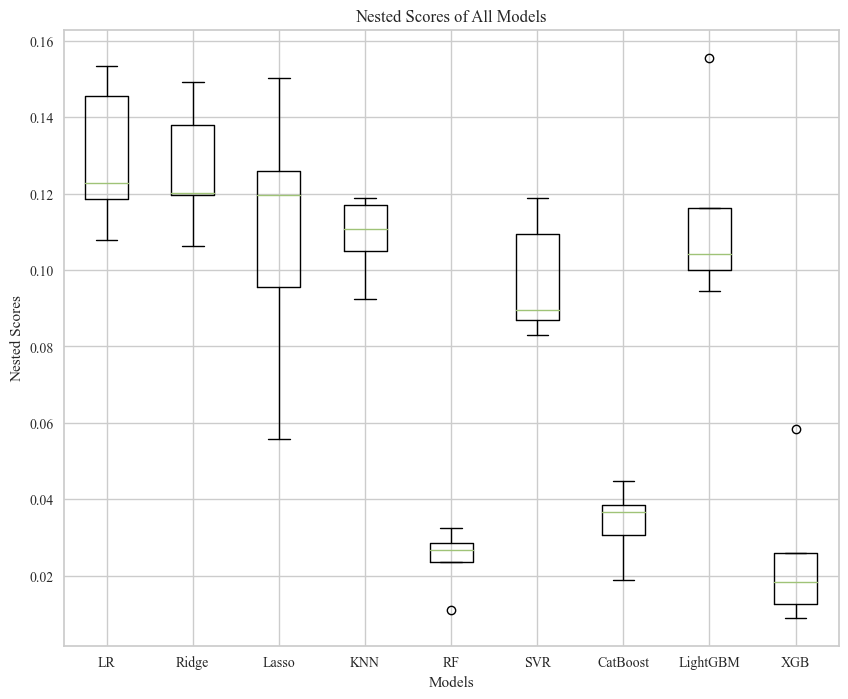

In [8]:
import matplotlib.pyplot as plt

# Combine all nested scores
nested_scores = [
    nested_scores_LR,
    nested_scores_ridge,
    nested_scores_lasso,
    nested_scores_knn,
    nested_scores_rf,
    nested_scores_svr,
    nested_scores_catboost,
    nested_scores_lgbm,
    nested_scores_xgb
]

# Create a boxplot
plt.figure(figsize=(10,8))
plt.boxplot(nested_scores, labels=["LR", "Ridge", "Lasso", "KNN", "RF", "SVR", "CatBoost", "LightGBM", "XGB"])
plt.xlabel("Models")
plt.ylabel("Nested Scores")
plt.title("Nested Scores of All Models")
plt.show()


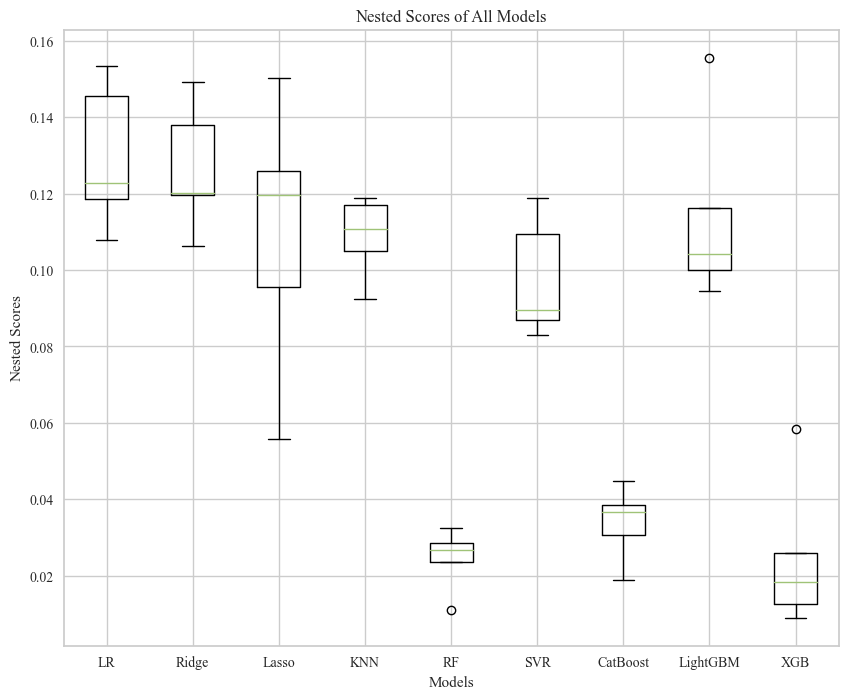

In [9]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 200),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    
    model = RandomForestRegressor(**params)
    
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    mae = -scores.mean()
    
    return mae

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
final_model = RandomForestRegressor(**best_params)
final_model.fit(X_train, y_train)

[I 2024-02-13 16:45:26,672] A new study created in memory with name: no-name-c20d7651-c421-4c20-8284-aa84a9d40645
[I 2024-02-13 16:45:27,395] Trial 0 finished with value: 0.07889755110486889 and parameters: {'n_estimators': 145, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 0 with value: 0.07889755110486889.
[I 2024-02-13 16:45:28,433] Trial 1 finished with value: 0.07739503777917964 and parameters: {'n_estimators': 183, 'max_depth': 8, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'auto'}. Best is trial 1 with value: 0.07739503777917964.
[I 2024-02-13 16:45:28,850] Trial 2 finished with value: 0.07760647471415347 and parameters: {'n_estimators': 80, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'log2'}. Best is trial 1 with value: 0.07739503777917964.
[I 2024-02-13 16:45:29,725] Trial 3 finished with value: 0.09948062883715662 and parameters: {'n_estimators': 151, 'max_depth': 3, 

RandomForestRegressor(max_depth=8, max_features='auto', min_samples_split=3,
                      n_estimators=112)

In [10]:
def bootstrap(X, y, model: object, n: int = 100):
    mae_values = []
    for i in tqdm(range(n)):
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.30, random_state=i
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        mae_values.append(mean_absolute_error(y_test, y_pred))
    return mae_values

mae_values = bootstrap(X_train, y_train, final_model)
print(f"Bootstraped Mean(MAE) = {np.mean(mae_values)}")
final_model.fit(X_train, y_train)

100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Bootstraped Mean(MAE) = 0.035811490855221735


RandomForestRegressor(max_depth=8, max_features='auto', min_samples_split=3,
                      n_estimators=112)

In [11]:
with open("../models/rf_isoprenol.pkl", "wb") as f:
    final_model.fit(X_train, y_train)
    pickle.dump(final_model, f)

#### Explainable AI 

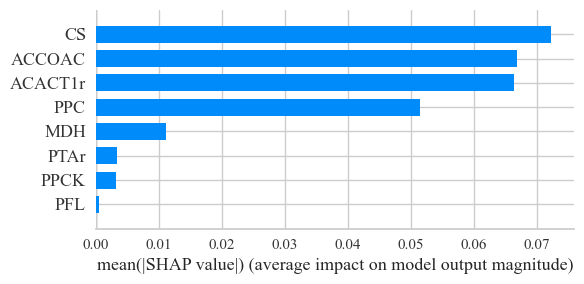

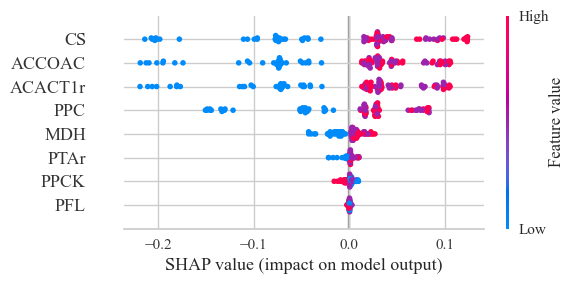

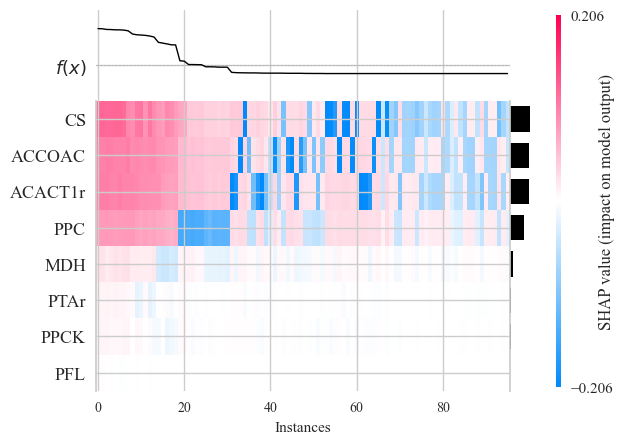

In [26]:
import shap
import matplotlib.pyplot as plt

def pdplot(X: np.array, col: str, model: object, ice: bool = False):
    shap.plots.partial_dependence(
        col,
        model.predict,
        X,
        ice=ice,
        model_expected_value=True,
        feature_expected_value=True,
        show=True,
    )


def shap_scatter(feature: str, color=None):
    if color:
        shap.plots.scatter(shap_values[:, feature], color=shap_values[:, color])
    else:
        shap.plots.scatter(shap_values[:, feature])

explainer = shap.TreeExplainer(final_model, df[INPUT_VARS])
shap_values = explainer(df[INPUT_VARS])
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="bar", plot_size=(6, 3))
shap.summary_plot(shap_values, df[INPUT_VARS], plot_type="dot", plot_size=(6, 3))
shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1), plot_width=6)

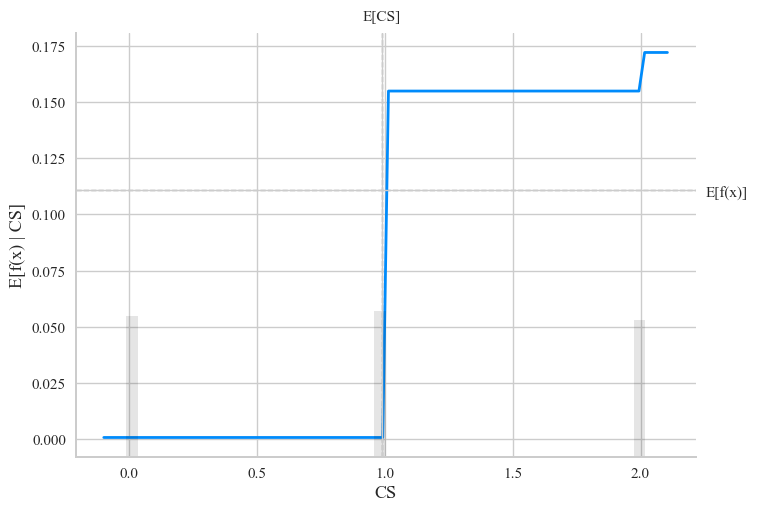

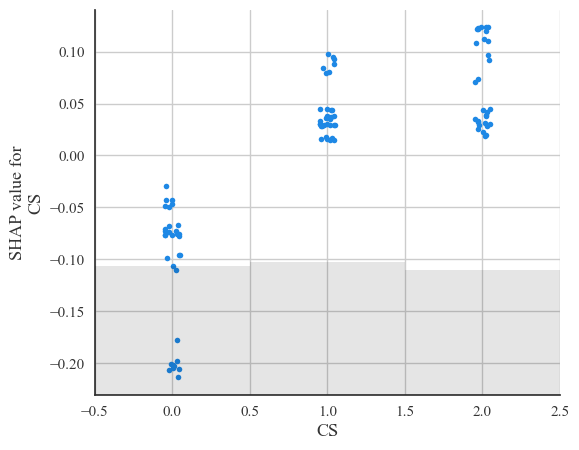

In [27]:
feature = "CS"
pdplot(df[INPUT_VARS], feature, final_model, ice=False)
shap_scatter(feature)

# Supervised clustering

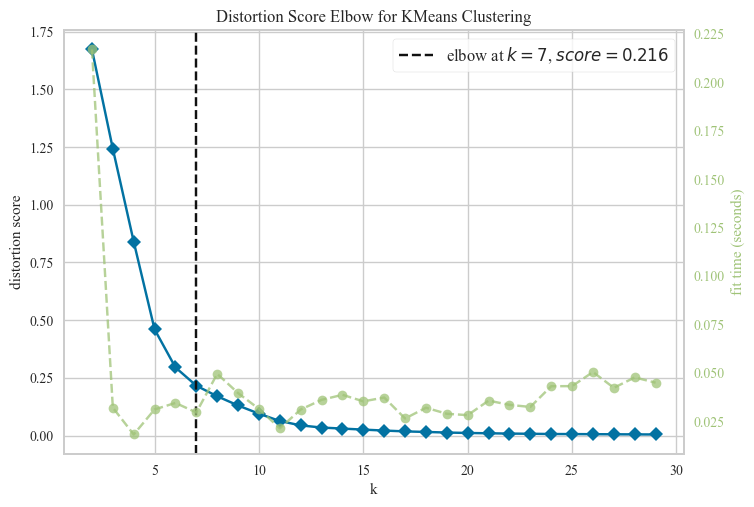

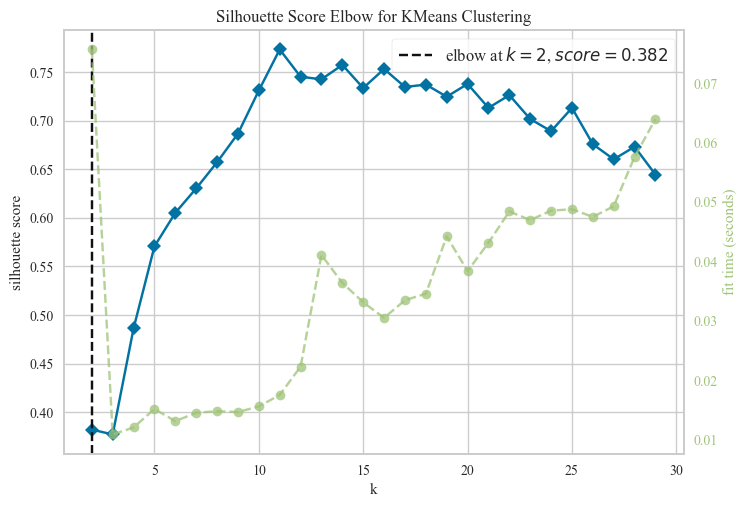

In [28]:
# Elbow Method for K means# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

def elbow_method(shap_values: np.array, model: object = KMeans(), metric: str = "elbow"):
    if metric=='elbow':
        visualizer = KElbowVisualizer(model, k=(2, 30), timings=True)
    else:
        visualizer = KElbowVisualizer(model, k=(2, 30), metric=metric, timings=True)
    visualizer.fit(shap_values)  # Fit data to visualizer
    visualizer.show()  # Finalize and render figure
    return visualizer.elbow_value_
    
def train_clustering(n_clusters: int, model: object = KMeans()):
    cls = model(n_clusters=n_clusters)
    clusters = cls.fit_predict(shap_values.values)
    return clusters


optimal_k_elbow = elbow_method(shap_values.values, model=KMeans())
optimal_k_silh = elbow_method(shap_values.values, model=KMeans(), metric='silhouette')\

clusters = train_clustering(optimal_k_silh, model=KMeans)


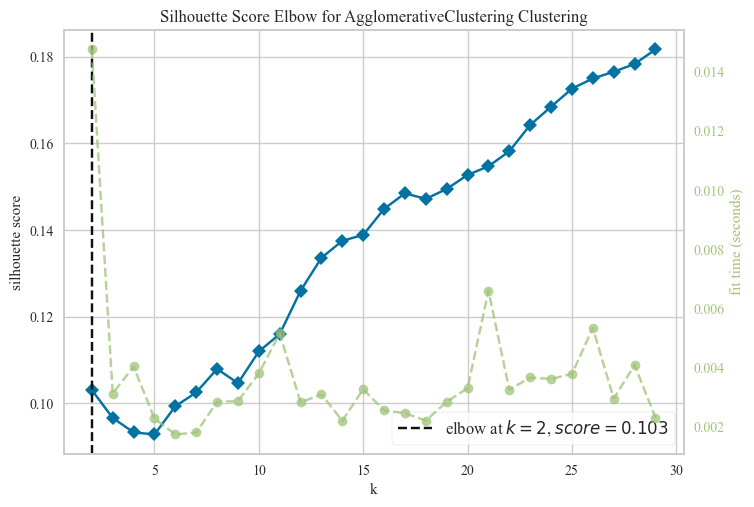

ACCOAC  MDH      PTAr        CS   ACACT1r       PPC      PPCK  \
cluster                                                                    
0        0.769231  1.0  0.969231  0.769231  0.800000  1.076923  1.030769   
1        1.516129  1.0  1.064516  1.451613  1.419355  0.806452  0.967742   

              PFL     Value  
cluster                      
0        0.984615  0.000000  
1        1.032258  0.337272

In [29]:
k = elbow_method(df[INPUT_VARS], model=AgglomerativeClustering(), metric='silhouette')
cls = train_clustering(k, model=AgglomerativeClustering)
df['cluster'] = cls 
# Group by cluster and calculate the mean
df.groupby('cluster').mean().sort_values('Value')



In [30]:
shap_values_df = pd.DataFrame(shap_values.values, columns=INPUT_VARS)
shap_values_df["cluster"] = clusters
shap_values_df['Value'] = df['Value'].values

# Grouping the data by cluster
cluster_means = shap_values_df.groupby('cluster').mean()
cluster_means = cluster_means.sort_values(by='Value', ascending=False)
display(cluster_means)

df['cluster'] = clusters
# Group by cluster and calculate the mean
df.groupby('cluster').median().sort_values('Value')

ACCOAC       MDH      PTAr        CS   ACACT1r       PPC      PPCK  \
cluster                                                                         
0        0.076544  0.000398  0.000459  0.081760  0.075148 -0.007083  0.001086   
1       -0.036506 -0.000190 -0.000219 -0.038993 -0.035840  0.003378 -0.000518   

              PFL     Value  
cluster                      
0        0.000023  0.337272  
1       -0.000011  0.000000

ACCOAC  MDH  PTAr   CS  ACACT1r  PPC  PPCK  PFL    Value
cluster                                                          
1           1.0  1.0   1.0  1.0      1.0  1.0   1.0  1.0  0.00000
0           2.0  1.0   1.0  1.0      1.0  1.0   1.0  1.0  0.36721

# Sampling

In [27]:
sampling_bounds = pd.DataFrame(columns=INPUT_VARS, index=['min', 'max'])
sampling_bounds['ACCOAC'].loc['min'] = 1
sampling_bounds['ACCOAC'].loc['max'] = 2

sampling_bounds['MDH'].loc['min'] = 1
sampling_bounds['MDH'].loc['max'] = 2

sampling_bounds['PTAr'].loc['min'] = 1
sampling_bounds['PTAr'].loc['max'] = 2

sampling_bounds['CS'].loc['min'] = 1
sampling_bounds['CS'].loc['max'] = 2

sampling_bounds['ACACT1r'].loc['min'] = 0
sampling_bounds['ACACT1r'].loc['max'] = 2

sampling_bounds['PPC'].loc['min'] = 0
sampling_bounds['PPC'].loc['max'] = 2

sampling_bounds['PPCK'].loc['min'] = 0
sampling_bounds['PPCK'].loc['max'] = 2

sampling_bounds['PFL'].loc['min'] = 0
sampling_bounds['PFL'].loc['max'] = 2

In [34]:
# Draw samples fiven the above bounds
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=len(INPUT_VARS))
sample = sampler.random(10)
LB = sampling_bounds.T["min"].values.tolist()
UB = sampling_bounds.T["max"].values.tolist()

sample_df = pd.DataFrame(qmc.scale(sample, LB, UB), columns=INPUT_VARS)
sample_df = sample_df.round(0).astype(int)
sample_df["pred"] = final_model.predict(sample_df)
sample_df.drop_duplicates(inplace=True)
sample_df.sort_values("pred", ascending=False, inplace=True)
sample_df

ACCOAC  MDH  PTAr  CS  ACACT1r  PPC  PPCK  PFL      pred
0       1    2     0   2        2    1     1    1  0.582315
9       1    2     2   2        2    1     2    0  0.554049
6       0    1     1   2        0    1     1    1  0.493100
1       0    0     0   1        1    1     0    2  0.478643
4       0    0     0   1        0    2     1    0  0.465058
2       1    1     1   1        1    1     1    1  0.462780
3       1    1     1   1        1    0     0    1  0.457005
5       2    0     2   0        1    1     2    2  0.435078
8       2    1     2   0        1    2     1    1  0.431859

## CTGAN

In [9]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=100, embedding_dim=128, generator_dim=(256, 256), discriminator_dim=(256, 256),
              discriminator_lr=0.001, generator_lr=0.001, batch_size=10, log_frequency=True, verbose=True)
ctgan.fit(df[INPUT_VARS], INPUT_VARS)
synthetic_data = ctgan.sample(10000)
synthetic_data['pred'] = final_model.predict(synthetic_data)
synthetic_data.sort_values("pred", ascending=False, inplace=True)
synthetic_data

Gen. (0.96) | Discrim. (1.51): 100%|██████████| 100/100 [00:17<00:00,  5.56it/s] 


ACCOAC  MDH  PTAr  CS  ACACT1r  PPC  PPCK  PFL      pred
994        1    2     2   2        2    0     0    2  0.573937
6153       1    2     2   2        2    0     1    2  0.573937
7028       1    1     2   2        2    1     0    2  0.573937
9790       1    1     1   2        2    0     1    2  0.573937
7161       1    1     1   2        2    1     2    2  0.573937
...      ...  ...   ...  ..      ...  ...   ...  ...       ...
5826       2    0     0   0        1    2     2    2 -0.008316
5875       2    0     2   0        0    2     2    2 -0.008316
9355       2    0     1   0        1    2     1    2 -0.008316
5899       2    0     0   0        0    2     1    2 -0.008316
9063       2    0     1   0        0    2     0    2 -0.008316

[10000 rows x 9 columns]

# Counterfactuals (`DiCE`)

In [16]:
import dice_ml
from dice_ml.utils import helpers

sorted_idx = df.sort_values("Value", ascending=False).index
df[INPUT_VARS] = df[INPUT_VARS].loc[sorted_idx]


def bounds_to_dict(bounds: pd.DataFrame):
    bounds_dict = bounds.to_dict()
    bounds_dict = {k: [v["min"], v["max"]] for k, v in bounds_dict.items()}
    return bounds_dict


query_instances = df[INPUT_VARS][0:1]

d = dice_ml.Data(
    dataframe=df, continuous_features=INPUT_VARS, outcome_name=RESPONSE_VARS[0]
)
m = dice_ml.Model(model=final_model, backend="sklearn", model_type="regressor")
exp = dice_ml.Dice(d, m, method="genetic")
e1 = exp.generate_counterfactuals(query_instances, total_CFs=4, desired_range=[0.50, 1])

cf_df = e1.cf_examples_list[0].final_cfs_df
e1.visualize_as_dataframe(show_only_changes=True)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

Query instance (original outcome : 0.5216761231422424)


ACCOAC  MDH  PTAr  CS  ACACT1r  PPC  PPCK  PFL     Value
0       1    1     2   0        2    0     0    0  0.521676


Diverse Counterfactual set (new outcome: [0.5, 1])


ACCOAC MDH PTAr CS ACACT1r  PPC PPCK PFL               Value
0      -   -    -  -       -    -    -   -                   -
0    0.0   -    -  -       -    -    -   -                   -
0      -   -  0.0  -       -    -    -   -  0.5455505847930908
0      -   -    -  -       -  2.0    -   -  0.5213491320610046